In [4]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

In [5]:
# read in dataset Jill
dset = pd.read_csv('Robin Kirkman - 05-26-2016.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second

In [6]:
#Variables
f=20
print(str(dset.shape[0]) + " data points at " + str(f) + "Hz")
print(str(dset.shape[0]/(60*f)) + " minutes")

104137 data points at 20Hz
86.78083333333333 minutes


In [7]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) #Picking all the data
#d = pd.DataFrame(data = dset[0:25000]) #Select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/f) # add timestamp assuming 10 samples / second

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,f)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['bmav'] = d['belly'].rolling(window = 7*f,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
#d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]>0].values[-10:])
#d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph1_slp'][0:int(x/(1/f))]<0].values[-10:])
#d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/f))][d['ph2_slp'][0:int(x/(1/f))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
#d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
#d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
#d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
#d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
#d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

#d['brmav'] = d['brlast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x)
#d['bfmav'] = d['bflast'].rolling(window = 30*f, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
#d['brfmav'] = (d['brmav']+ d['bfmav'])/2

# movement data acceleration
d['acc'] = (d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])).apply(np.sqrt)

# movement data angular velocity
d['gyr'] = (d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])).apply(np.sqrt)

Autonomic: 43.2183333333 minutes
Autonomic light: 87.9066666667 minutes
Normal breathing: 33.85 minutes
Cardio: 6.06333333333 minutes
 Total: 171.038333333 minutes


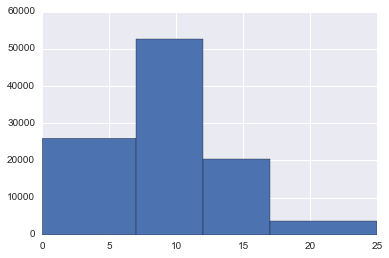

In [8]:
#Calculate the occurrence of each breathing type
occurrence=d['rfmav'].hist(bins=[0,7,12,17,25])
def get_hist(ax):
    n=[]
    for rect in ax.patches:
        ((x0, y0), (x1, y1)) = rect.get_bbox().get_points()
        n.append(y1-y0)
    return n
n = get_hist(occurrence)

b1=n[0]/600
b2=n[1]/600
b3=n[2]/600
b4=n[3]/600

print("Autonomic: " + str(b1) + " minutes")
print("Autonomic light: " + str(b2) + " minutes")
print("Normal breathing: " + str(b3) + " minutes")
print("Cardio: " + str(b4) + " minutes")
print(" Total: " + str(b1+b2+b3+b4) + " minutes")

In [9]:
f = d

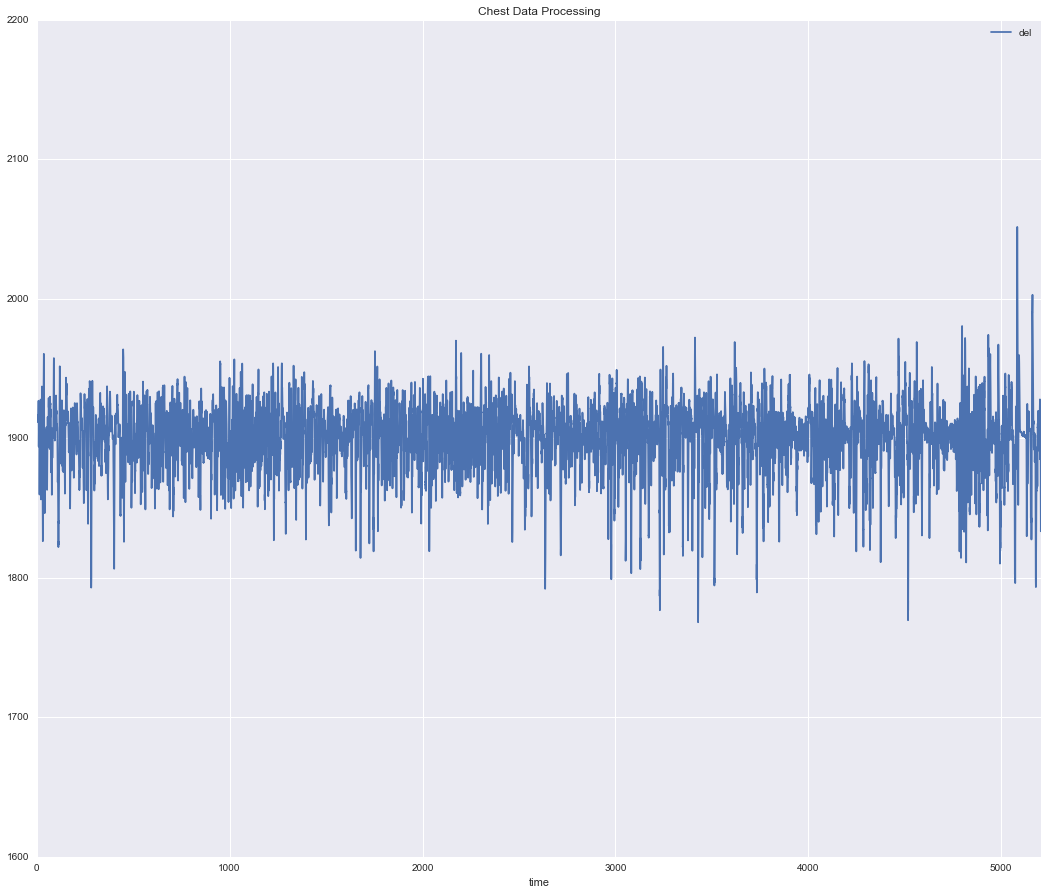

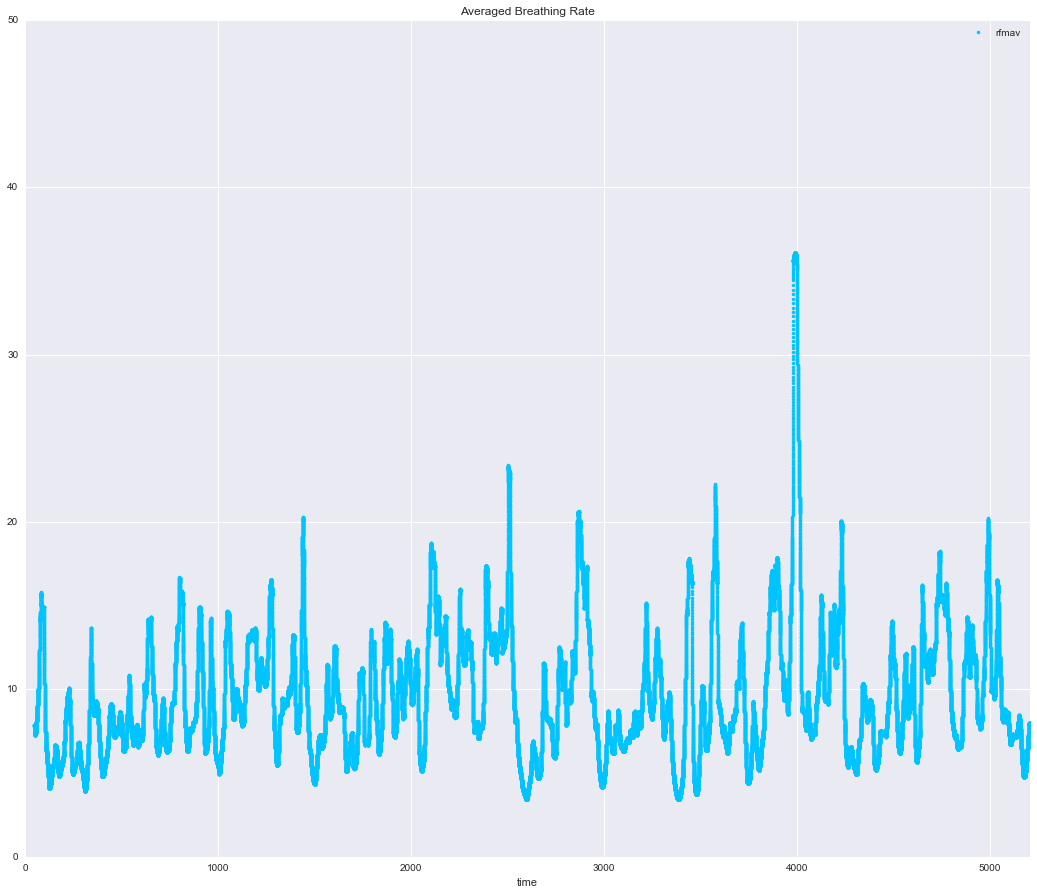

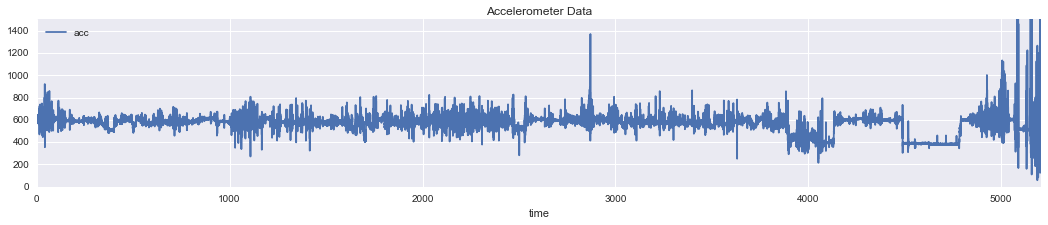

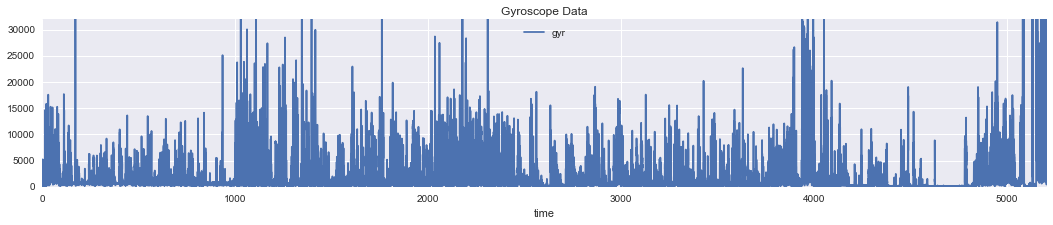

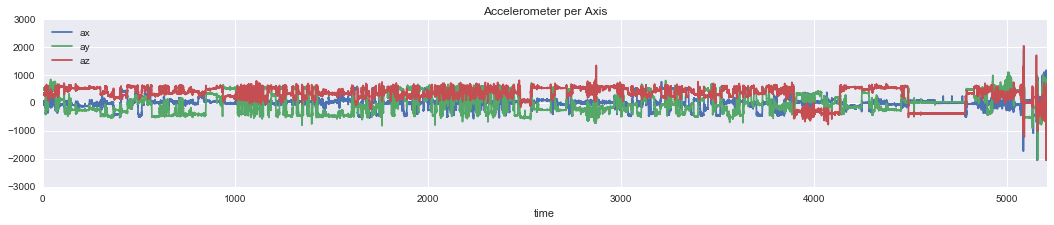

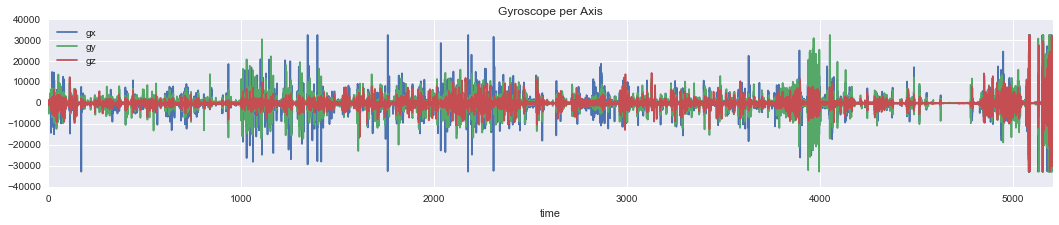

In [10]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,50), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3), ylim=(0,1500), title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3), ylim=(0,32000), title = 'Gyroscope Data')
d.plot(x = 'time',y = ['ax','ay','az'],figsize = (18,3), title = 'Accelerometer per Axis')
d.plot(x = 'time',y = ['gx','gy','gz'],figsize = (18,3), title = 'Gyroscope per Axis')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [11]:
print(d[::1000]) # every thousandth line of the processed dataset

         index  chest  belly   ax   ay   az     gx     gy      gz    time  \
0            0   2947   2908  -41  504  312     -3   -234  -294.0     0.0   
1000      1000   2866   2820  -23  481  294   1130    835 -1505.0    50.0   
2000      2000   3033   3021  -48  120  595   -368    408  -177.0   100.0   
3000      3000   2894   2859  -26 -228  550   -472    544  -414.0   150.0   
4000      4000   2987   2975 -113 -264  511   -405    437  -314.0   200.0   
5000      5000   2996   2964   19 -202  568   -237    448  -265.0   250.0   
6000      6000   2945   2931   28 -354  455  -3619   -207  -491.0   300.0   
7000      7000   2992   2904  -16 -493  249   -437    412  -352.0   350.0   
8000      8000   2934   2921 -400 -207  216   3087   -362  1283.0   400.0   
9000      9000   2900   2945   -9 -151  593   2537    744  -314.0   450.0   
10000    10000   2927   2983 -495   46  143   -122    891  -542.0   500.0   
11000    11000   2953   2969  531   -8  182   -711    517  -343.0   550.0   

In [12]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fbtime,rlast,flast,rmav,fmav,rfmav,acc,gyr,b1,b2
0,0,2947,2908,-41,504,312,-3,-234,-294.0,0.00,...,[nan],NaN,NaN,NaN,NaN,NaN,594.172534,375.767215,1900,1600
1,1,2952,2915,-45,504,313,-205,-135,-166.0,0.05,...,[nan],NaN,NaN,NaN,NaN,NaN,594.987395,296.320772,1900,1600
2,2,2954,2921,-50,502,321,-117,-478,-315.0,0.10,...,[nan],NaN,NaN,NaN,NaN,NaN,597.950667,584.292735,1900,1600
3,3,2960,2923,-40,500,316,-137,-417,-542.0,0.15,...,[nan],NaN,NaN,NaN,NaN,NaN,592.837246,697.439603,1900,1600
4,4,2962,2928,-40,499,319,-39,-120,-609.0,0.20,...,[nan],NaN,NaN,NaN,NaN,NaN,593.600876,621.934080,1900,1600
5,5,2966,2931,-40,502,316,65,160,-616.0,0.25,...,[nan],NaN,NaN,NaN,NaN,NaN,594.525020,639.750733,1900,1600
6,6,2962,2932,-44,502,316,6,412,-402.0,0.30,...,[nan],NaN,NaN,NaN,NaN,NaN,594.807532,575.659622,1900,1600
7,7,2963,2938,-49,503,318,20,503,-262.0,0.35,...,[nan],NaN,NaN,NaN,NaN,NaN,597.104681,567.497137,1900,1600
8,8,2963,2939,-45,504,318,9,783,134.0,0.40,...,[nan],NaN,NaN,NaN,NaN,NaN,597.632830,794.434390,1900,1600
9,9,2964,2941,-52,510,313,164,587,21.0,0.45,...,[nan],NaN,NaN,NaN,NaN,NaN,600.643821,609.840963,1900,1600
